## Running t-test over the results (simulations)

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.stats import ttest_rel
import pandas as pd
# from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline

## Aux funcs

In [30]:
def get_data(results_path):
    return pd.read_csv(
        results_path, 
        usecols=['GroupLasso', 'MrRCE', 'OLS', 'Ridge', 'rho', 'MRCE']
    )

In [21]:
def melt(data):
    return data.melt(
        id_vars='rho', 
        var_name='model', 
        value_name='err'
    )

In [203]:
def plot(data, figsize=(15, 5), ax=None, legend=True):
    fig = None
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    to_plot = data.groupby('rho', as_index=False).mean().melt(id_vars='rho')
    
    colors = ["#ea645d", "#e8b27d", "#83bc7e", "#557fa2", "#8354a1"]
    style = dict(
        OLS=("#ea645d", "+", "--"),
        GroupLasso=("#e8b27d", "x", (0, (5, 8))),
        Ridge=("#83bc7e", "*", "-"),
        MRCE=("#557fa2", "d", (0, (3, 1, 1, 1, 1, 1))),
        MrRCE=("#8354a1", "s", (0, (3, 3, 1, 3)))
    )

    for model, color_shape_line in style.items():
        tmp = to_plot.loc[to_plot.variable == model].copy()
        ax.plot(
            tmp.rho, 
            tmp.value, 
            label=model, 
            c=color_shape_line[0], 
            marker=color_shape_line[1],
            linestyle=color_shape_line[2],
            markersize=6 + (2 * (color_shape_line[1] != "s")),
            linewidth=2
        )
    
    if legend:
        ax.legend(
            loc='upper center',
            fancybox=True,
            shadow=True,
            ncol=5,
            fontsize='x-large',
            bbox_to_anchor=(0.5, 1.15)
        )

    ax.set_xlabel('$\\rho$', fontsize='x-large')
    ax.set_ylabel('Model Error (ME)', fontsize='x-large')
    
    # removing top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
    return fig, ax

In [165]:
# def plot(data):
#     return (
#         ggplot(
#             melt(data).groupby(['rho', 'model'], as_index=False).mean(), aes('rho', 'err', color='model'))
#             + geom_point()
#             + geom_line()
#             + theme_classic()
#         )

In [19]:
def unpivot(df):
    df['rank'] = df.groupby('model')['rho'].rank("first")
    u_df =  df.reset_index().pivot_table(
        columns='model', 
        values='err', 
        index=['rank', 'rho']
    )
    u_df.reset_index(inplace = True)
    u_df.drop(columns = 'rank', inplace = True)
    return u_df

In [44]:
def t_test(data):
    return pd.DataFrame(
    data.groupby('rho', as_index=False).apply(
        lambda df : {
            'GroupLasso': ttest_rel(df.GroupLasso, df.MrRCE).pvalue / 2,
            'OLS': ttest_rel(df.OLS, df.MrRCE).pvalue / 2,
            'Ridge': ttest_rel(df.Ridge, df.MrRCE).pvalue / 2,
            'MRCE': ttest_rel(df.MRCE, df.MrRCE).pvalue / 2
            }
    ).to_dict()
)

## Identity

In [189]:
data = get_data("full-simulations-results/identity.csv")

,0,1,2,3,4
GroupLasso,2.016727e-01,6.951208e-02,7.189142e-03,1.018312e-11,1.466999e-16
MRCE,1.168411e-20,1.025834e-12,6.884048e-19,3.055960e-27,3.019943e-43
OLS,1.014520e-50,6.287830e-51,4.314518e-52,4.457434e-60,8.088290e-78
Ridge,2.105453e-07,1.666161e-07,1.133187e-12,2.785701e-30,4.221760e-42


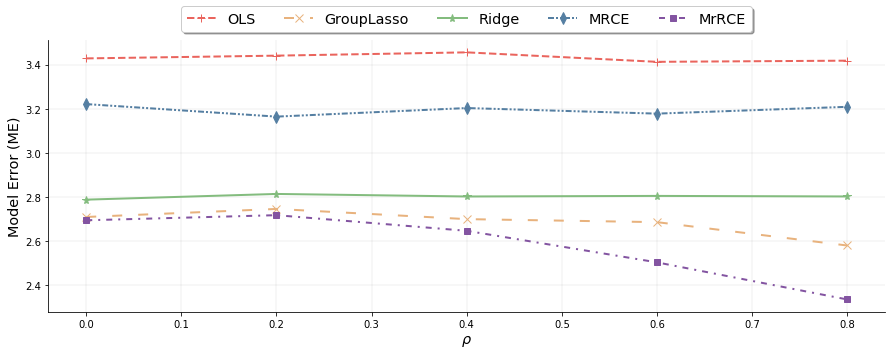

In [190]:
display(t_test(data))
fig, ax = plot(data)

In [191]:
fig.savefig("plots/identity_full.png", bbox_inches='tight')

## AR dense

In [192]:
data = get_data("full-simulations-results/ar_dense.csv")

,0,1,2,3,4
GroupLasso,6.706459e-33,6.384621e-26,1.382136e-33,5.096280e-44,8.259934e-60
MRCE,2.895359e-12,5.467184e-07,5.314673e-10,5.319920e-21,2.385107e-35
OLS,4.818500e-27,4.517625e-24,5.104729e-34,1.816043e-45,1.614851e-62
Ridge,1.832838e-20,3.558748e-13,6.421084e-25,6.675235e-45,4.573754e-62


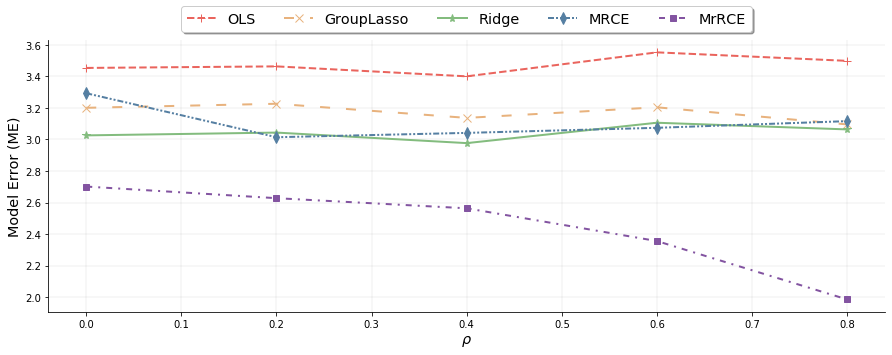

In [193]:
display(t_test(data))
fig, _ = plot(data)
fig.savefig("plots/ar_dense_full.png", bbox_inches='tight')

## AR sparse

In [194]:
ar_dense = data.copy()

In [195]:
data = get_data("full-simulations-results/ar_sparse.csv")

,0,1,2,3,4
GroupLasso,3.776682e-19,1.563315e-23,1.467052e-27,1.072144e-31,9.150660e-46
MRCE,4.791588e-04,1.054455e-09,3.937794e-13,6.250345e-18,3.258335e-32
OLS,5.030218e-37,2.108110e-39,3.547337e-45,2.218872e-52,3.690253e-51
Ridge,1.031264e-23,2.731966e-25,1.893632e-30,1.355672e-39,2.922390e-47


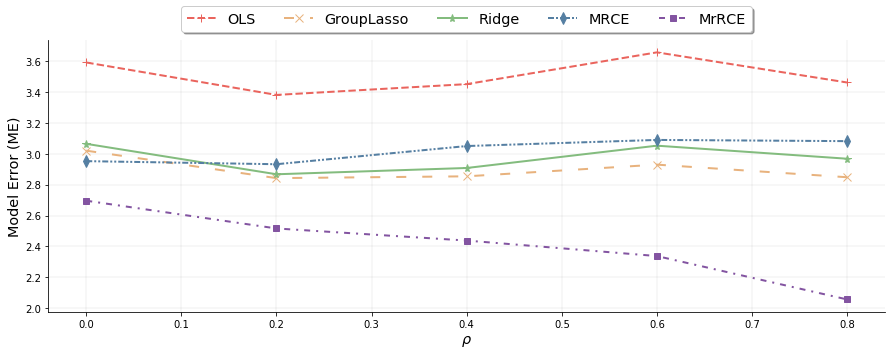

In [196]:
display(t_test(data))
fig, _ = plot(data)
fig.savefig("plots/ar_sparse_full.png", bbox_inches='tight')

## Both AR

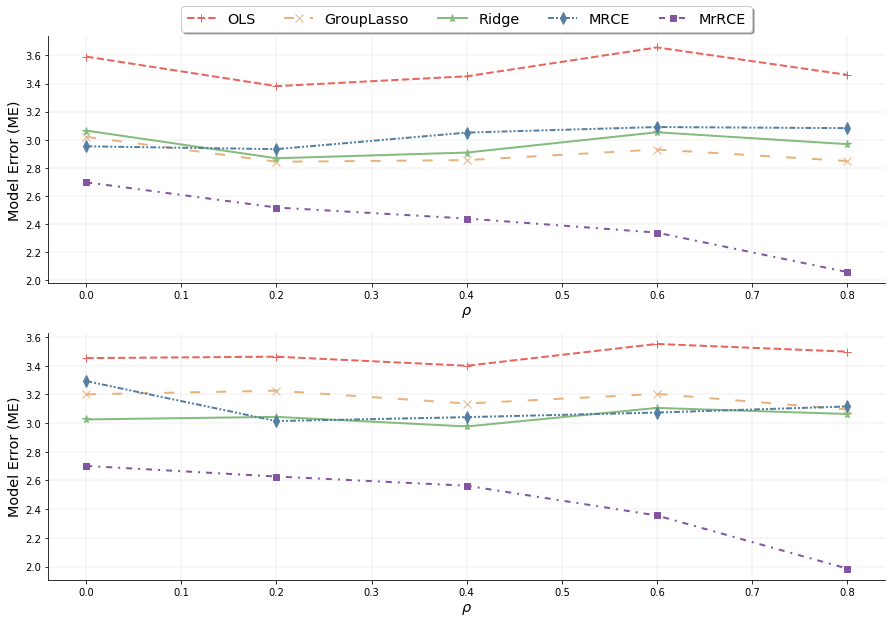

In [204]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 10))
plot(data, ax=axes[0])
plot(ar_dense, ax=axes[1], legend=False)

fig.savefig("plots/ar_sparse_dense_full.png", bbox_inches='tight')

## Equi

In [205]:
data = get_data("full-simulations-results/equi.csv")

,0,1,2,3,4
GroupLasso,1.094327e-42,5.436506e-42,1.727072e-47,2.172888e-53,2.804710e-61
MRCE,6.302719e-09,1.828860e-10,1.628482e-10,2.372929e-19,2.075753e-35
OLS,1.699702e-42,2.757219e-37,1.722752e-39,1.781721e-53,1.408145e-55
Ridge,5.535146e-43,1.029715e-34,3.209862e-39,3.488981e-53,2.721897e-60


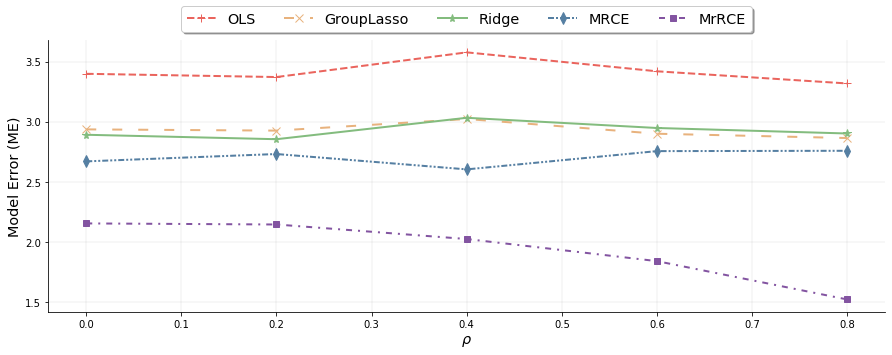

In [206]:
display(t_test(data))
fig, _ = plot(data)
fig.savefig("plots/equi_full.png", bbox_inches='tight')

## FGN

In [207]:
data = get_data("full-simulations-results/fgn.csv")

,0,1,2,3,4
GroupLasso,4.424107e-39,7.725811e-43,8.272071e-46,4.137811e-53,4.869331e-57
MRCE,5.814335e-20,1.455682e-24,3.969335e-29,2.111345e-39,7.674220e-44
OLS,8.725864e-30,2.781868e-35,1.116611e-32,1.984061e-42,3.370678e-50
Ridge,3.330106e-29,7.267003e-30,1.049955e-33,4.085858e-43,1.954813e-52


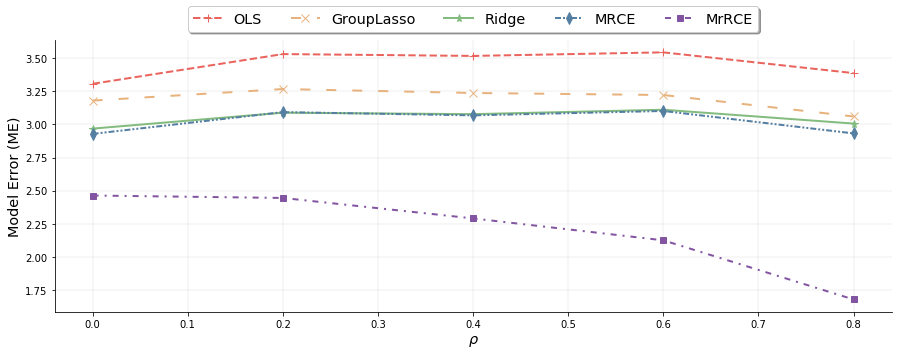

In [208]:
display(t_test(data))
fig, _ = plot(data)
fig.savefig("plots/fgn_full.png", bbox_inches='tight')